In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/model_analysis')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [5]:
trains = sorted(data['train'].unique().tolist())
len(trains)

94

## Модель

Здесь `PlacePriceModel` — модель, соответствующая уравнениям:

$$\begin{cases} n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\ C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau) \end{cases},$$

где $n(t, \tau)$ — число свободных мест и $C(t, \tau)$ — цена на поезд с отправлением в день $t$ за $\tau$ дней до отправления, $\mu(\tau)$ — среднее число свободных мест, $a(t)$ — главная компонента PCA, $V(\tau)$ — её ортогональная составляющая, $b_0$, $b_1$ — коэффициенты регрессии, $\delta(t, \tau)$, $\varepsilon(t, \tau)$ — ошибки PCA и линейной регрессии соответственно.

Вкратце: число свободных мест определяется по модели PCA, а зависимость цены от числа мест — линейной регрессией.

(На момент написания этой документации толковый анализ второй компоненты (т.е. зависимости цены от мест) не проводился, в основном только места.)

In [6]:
maxdays = 30

In [7]:
models = {}
metrics = []

for train in tqdm(trains):
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.to_csv(results_dir / 'model_metrics.csv', index=False)

metrics.head()

  0%|          | 0/94 [00:00<?, ?it/s]

,num,class,explained,r2,train
0,001А,Купе,0.792619,0.153085,001А-Купе
1,002А,Купе,0.814872,0.226177,002А-Купе
2,005А,СВ,0.844456,0.154320,005А-СВ
3,006А,СВ,0.849035,0.172454,006А-СВ
4,701Н,СВ,0.700852,0.165152,701Н-СВ


<AxesSubplot:xlabel='explained', ylabel='r2'>

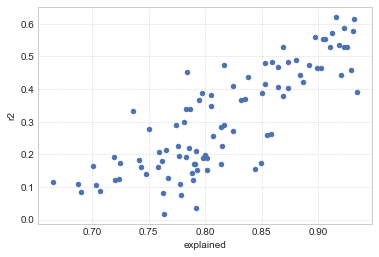

In [8]:
metrics.plot(kind='scatter', x='explained', y='r2')

Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [9]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

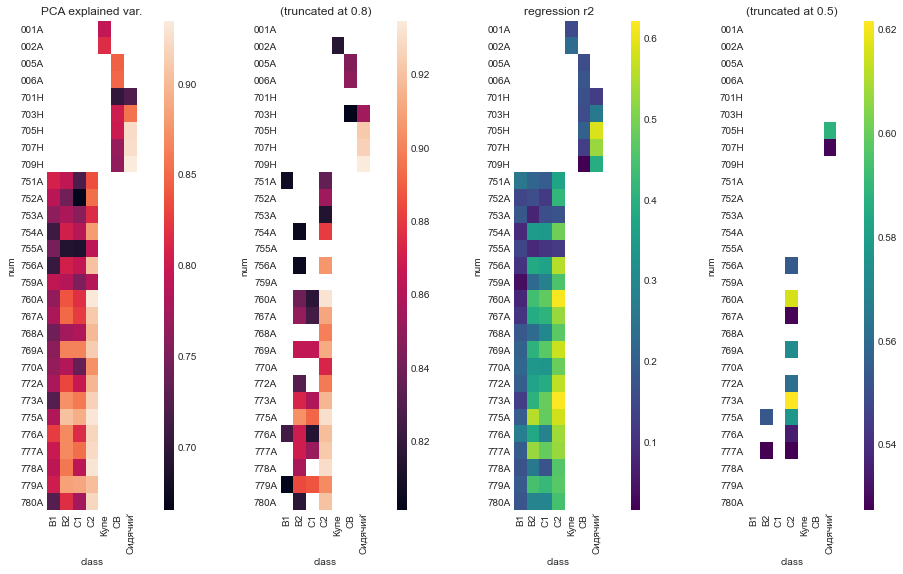

In [10]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 9)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.8)

sns.heatmap(explained, ax=ax2, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.8)')

sns.heatmap(r2, ax=ax3, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig(figures_dir / 'model_metrics.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [11]:
class_to_color = {cl: f'C{i}' for i, cl in enumerate(data['class'].unique())}
class_to_color

{'Купе': 'C0',
 'СВ': 'C1',
 'Сидячий': 'C2',
 'B1': 'C3',
 'B2': 'C4',
 'C1': 'C5',
 'C2': 'C6'}

Интерпретируем объяснённую дисперсию разных поездов.

1. Распределение ОД по классам.
2. Зависимость ОД от вместимости поездо-класса.
3. Зависимость ОД от медианной цены.

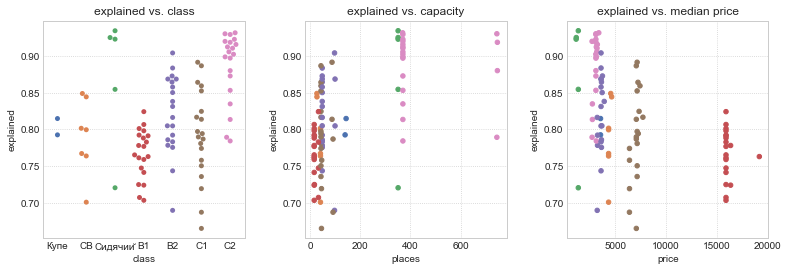

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(13, 4)
fig.subplots_adjust(wspace=0.3)

sns.swarmplot(ax=ax1, data=metrics, x='class', y='explained')
ax1.set_title('explained vs. class')

explained_vs_capacity = data.groupby('train')['places'].max().reset_index()\
    .merge(metrics[['train', 'explained']], on='train')
color = explained_vs_capacity['train'].apply(lambda x: class_to_color[x.split('-')[-1]])

explained_vs_capacity.plot(ax=ax2, kind='scatter', x='places', y='explained', color=color)

ax2.set_title('explained vs. capacity')

explained_vs_price = data.groupby('train')['price'].median().reset_index()\
    .merge(metrics[['train', 'explained']], on='train')
color = explained_vs_price['train'].apply(lambda x: class_to_color[x.split('-')[-1]])

explained_vs_price.plot(ax=ax3, kind='scatter', x='price', y='explained', color=color)

ax3.set_title('explained vs. median price')

plt.savefig(figures_dir / 'explaining_explained_variance.pdf', transparent=True, bbox_inches='tight')

В целом видим, что, как правило, "народные" поездо-классы (т.е. дешёвые билеты, много мест) дают больше объяснённой дисперсии в среднем. Но отличие не супер явное.

Сохраняем параметры моделей PCA для разных поездов.

In [13]:
explained_variance_ratio = {}
a = {}
mean = {}
v = {}

for train, model in models.items():
    explained_variance_ratio[train] = model.impute_pca.explained_variance_ratio
    
    if model.explained_variance >= 0.8:
        a[train] = model.a
        mean[train] = model.mu
        v[train] = model.v

explained_variance_ratio = pd.DataFrame(explained_variance_ratio).T
a = pd.DataFrame(a)
v = pd.DataFrame(v).T
mean = pd.DataFrame(mean).T

for df in [explained_variance_ratio, v, mean]:
    df.index.name = 'train'
    df.columns.name = None

explained_variance_ratio.reset_index().to_csv(results_dir / 'explained_variance_ratios.csv', index=False)
a.reset_index().to_csv(results_dir / 'principal_components.csv', index=False)
v.reset_index().to_csv(results_dir / 'eigenvectors.csv', index=False)
mean.reset_index().to_csv(results_dir / 'means.csv', index=False)

### Поезда с низкой EVR

In [14]:
mask = metrics['explained'] <= 0.7

metrics[mask]

,num,class,explained,r2,train
20,752А,C1,0.665063,0.116321,752А-C1
31,755А,B2,0.689685,0.083736,755А-B2
32,755А,C1,0.687151,0.109917,755А-C1


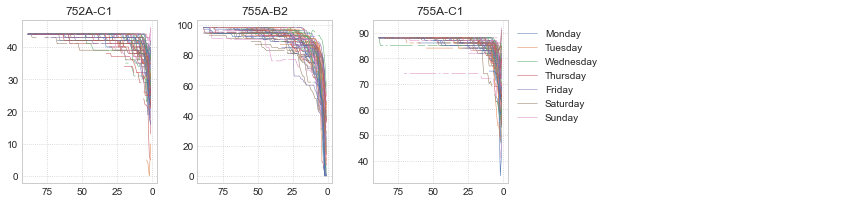

In [15]:
ncols = 5
nrows = mask.sum() // ncols + (mask.sum() % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
axes = axes.flatten()

for train, ax in zip(metrics.loc[mask, 'train'], axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
for i in range(mask.sum(), len(axes)):
    axes[i].axis('off')
    
plt.savefig(figures_dir / 'poorly_explained.pdf', transparent=True, bbox_inches='tight')

В двух случаях из трёх видим нехарактерные взлёты в последний день, причём даже выше, чем "плато". Возможно, это возвраты в последний день, но возможно и что РЖД тут тоже какие-то доп. вагоны добавляли.

По-хорошему, такие кейсы тоже надо бы вылавливать на препроцессинге и удалять, но на момент написания этой документации такое мы не делали.

### Главные компоненты и их автокорреляции по разным поездам

## PCA

## Кластеризация по $\mu(\tau)$

Кластеризуем поезда по значениям вектора $\mu(\tau)$ (т.е. средней заполняемости в течение последних 30 дней до отправления).

Кластеризуем по оригинальным векторам, но параллельно ещё смотрим на их производные (вдруг чего интересного увидим).

In [25]:
deriv_mean = (mean - mean.shift(-1, axis=1)).drop(columns=30)

deriv_mean.head(2)

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
train,,,,,,,,,,,,,,,,,,,,,
002А-Купе,-0.045823,-0.051990,-0.046618,-0.039775,-0.032520,-0.030652,-0.025734,-0.018514,-0.019996,-0.013886,...,-0.013254,-0.011442,-0.009387,-0.010491,-0.006113,-0.007540,-0.006263,-0.005117,-0.004619,-0.005443
005А-СВ,-0.060917,-0.038721,-0.033130,-0.031481,-0.030563,-0.014677,-0.022309,-0.015215,-0.025000,-0.020841,...,-0.009083,-0.006654,-0.006269,-0.004508,-0.007737,-0.006968,-0.008023,-0.007045,-0.012231,-0.006570


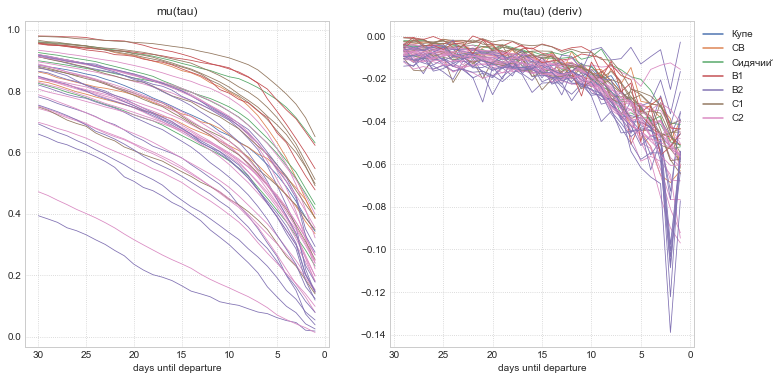

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)

for train in mean.index:
    color = class_to_color[train.split('-')[-1]]
    
    ax1.plot(mean.loc[train], c=color, lw=0.8)
    ax2.plot(deriv_mean.loc[train], c=color, lw=0.8)

handles = []
labels = []

for cl, color in class_to_color.items():
    labels.append(cl)
    handles.append(plt.Line2D([0, 1], [0, 0], color=color))
    
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

for ax in [ax1, ax2]:
    ax.set_xlabel('days until departure')
    ax.invert_xaxis()

ax1.set_title('mu(tau)')
ax2.set_title('mu(tau) (deriv)')

plt.savefig(figures_dir / 'means.pdf', transparent=True, bbox_inches='tight')

Кластеризуем.

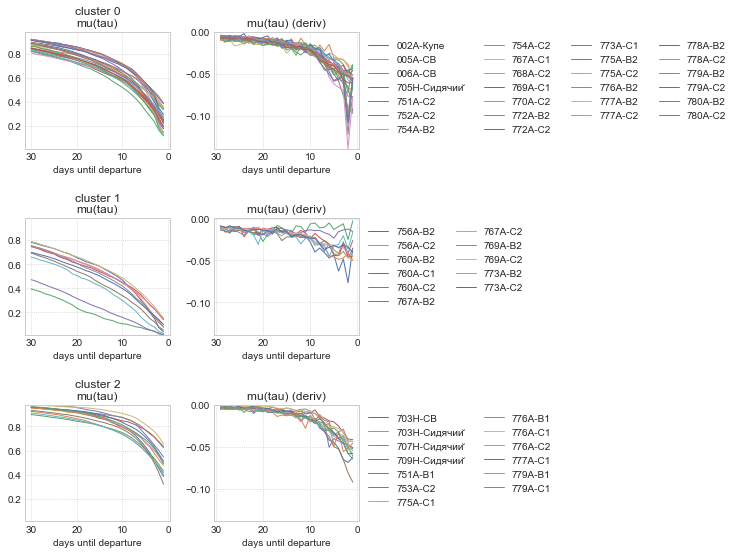

In [27]:
k = 3
kmeans = KMeans(n_clusters=k).fit(mean.values)
mu_clusters = kmeans.predict(mean.values)

ncols = 2
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.6)

mu_min = mean.min().min()
mu_max = mean.max().max()

int_mu_min = deriv_mean.min().min()
int_mu_max = deriv_mean.max().max()

for cluster, (ax1, ax2) in zip(np.unique(mu_clusters), axes):
    mean_i = mean.loc[mu_clusters == cluster]
    deriv_mean_i = deriv_mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1)
    deriv_mean_i.T.plot(ax=ax2, lw=1)
    
    ax1.set_title(f'cluster {cluster}\nmu(tau)')
    ax2.set_title(f'mu(tau) (deriv)')
    
    ax1.set_ylim(mu_min, mu_max)
    ax2.set_ylim(int_mu_min, int_mu_max)

    ax1.legend().set_visible(False)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('days until departure')
        ax.invert_xaxis()

plt.savefig(figures_dir / 'mean_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Интерпретируем кластеры:

1. Сопоставляем их с классами обслуживания.
2. Сопоставляем с временем прибытия.
3. Сопоставляем с ценой.

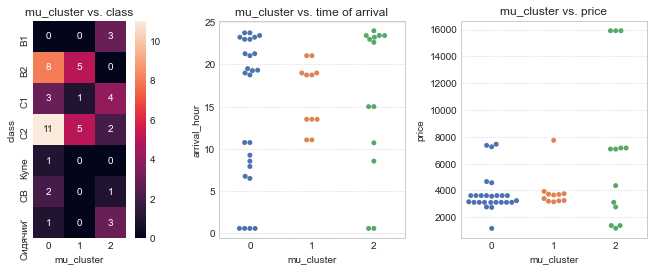

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.3)

train_class = mean.index.map(lambda x: x.split('-')[1])

sns.heatmap(pd.crosstab(mu_clusters, train_class).T, square=True, ax=ax1, annot=True)
ax1.set_xlabel('mu_cluster')
ax1.set_ylabel('class')
ax1.set_title('mu_cluster vs. class')

df = pd.Series(mu_clusters, index=mean.index, name='mu_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_hour']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='mu_cluster', y='arrival_hour', ax=ax2)
ax2.set_title('mu_cluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'mu_cluster': mu_clusters, 'price': avg_price})

sns.swarmplot(data=df, x='mu_cluster', y='price', ax=ax3)
ax3.set_title('mu_cluster vs. price')

plt.savefig(figures_dir / 'explaining_mean_clusters.pdf', transparent=True, bbox_inches='tight')

Выводы: да хрен знает, особых выводов тут не сделаешь. Эти кластеры не особо интерпретируются тем, что тут нарисовано.

## Кластеризация по $V(\tau)$

In [29]:
deriv_v = (v - v.shift(-1, axis=1)).drop(columns=30)

deriv_v.head(2)

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
train,,,,,,,,,,,,,,,,,,,,,
002А-Купе,-0.013222,-0.018348,-0.017840,-0.014040,-0.005853,-0.005479,0.000218,-0.001281,-0.001810,0.001092,...,0.014122,0.010825,0.009820,0.011247,0.005489,0.005270,0.004689,0.002781,0.003036,0.005143
005А-СВ,-0.010132,-0.014696,-0.007982,-0.002486,-0.003936,-0.006116,-0.002561,-0.000285,0.018827,0.008139,...,0.008993,0.008965,0.011674,0.002402,0.008703,0.005496,0.005932,0.007381,0.012876,0.002880


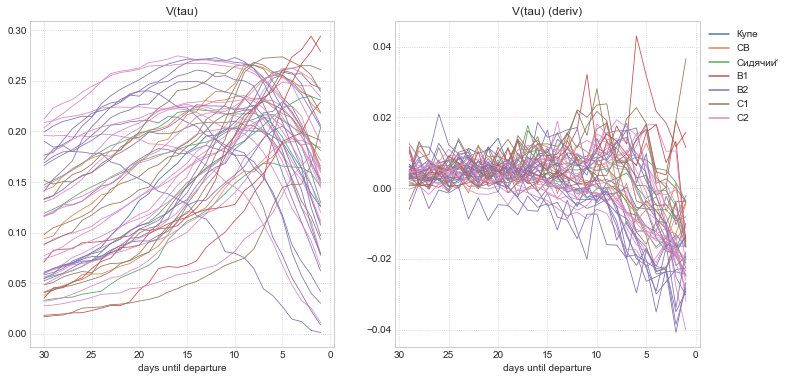

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 6)

for train in v.index:
    color = class_to_color[train.split('-')[-1]]
    
    ax1.plot(v.loc[train], c=color, lw=0.8)
    ax2.plot(deriv_v.loc[train], c=color, lw=0.8)

handles = []
labels = []

for cl, color in class_to_color.items():
    labels.append(cl)
    handles.append(plt.Line2D([0, 1], [0, 0], color=color))
    
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

for ax in [ax1, ax2]:
    ax.set_xlabel('days until departure')
    ax.invert_xaxis()

ax1.set_title('V(tau)')
ax2.set_title('V(tau) (deriv)')

plt.savefig(figures_dir / 'eigenvectors.pdf', transparent=True, bbox_inches='tight')

Кластеризуем.

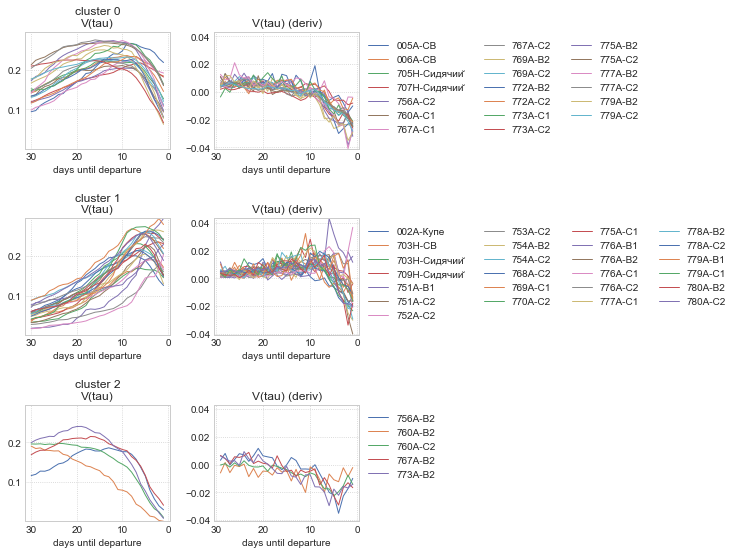

In [31]:
k = 3
kmeans = KMeans(n_clusters=k).fit(v.values)
eig_clusters = kmeans.predict(v.values)

ncols = 2
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.6)

vmin = v.min().min()
vmax = v.max().max()

int_vmin = deriv_v.min().min()
int_vmax = deriv_v.max().max()

for cluster, (ax1, ax2) in zip(np.unique(eig_clusters), axes):
    v_i = v.loc[eig_clusters == cluster]
    deriv_v_i = deriv_v.loc[eig_clusters == cluster]
    
    v_i.T.plot(ax=ax1, lw=1)
    deriv_v_i.T.plot(ax=ax2, lw=1)
    
    ax1.set_title(f'cluster {cluster}\nV(tau)')
    ax2.set_title(f'V(tau) (deriv)')
    
    ax1.set_ylim(vmin, vmax)
    ax2.set_ylim(int_vmin, int_vmax)

    ax1.legend().set_visible(False)
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=v_i.shape[0] // 8 + 1)
    
    for ax in [ax1, ax2]:
        ax.set_xlabel('days until departure')
        ax.invert_xaxis()

plt.savefig(figures_dir / 'eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

Интерпретируем кластеры (тем же образом, что и ранее с $\mu$).

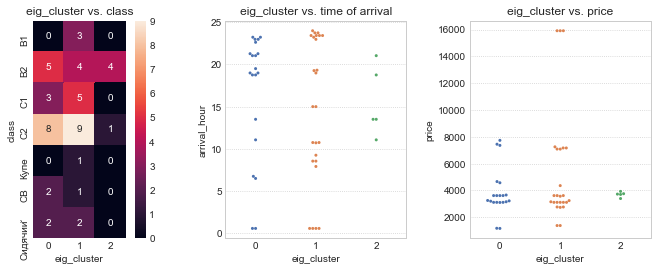

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 4)
fig.subplots_adjust(wspace=0.35)

train_class = v.index.map(lambda x: x.split('-')[1])

sns.heatmap(pd.crosstab(eig_clusters, train_class).T, square=True, ax=ax1, annot=True)
ax1.set_xlabel('eig_cluster')
ax1.set_ylabel('class')
ax1.set_title('eig_cluster vs. class')

df = pd.Series(eig_clusters, index=mean.index, name='eig_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_hour']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='eig_cluster', y='arrival_hour', ax=ax2, size=3)
ax2.set_title('eig_cluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'eig_cluster': eig_clusters, 'price': avg_price})

sns.swarmplot(data=df, x='eig_cluster', y='price', ax=ax3, size=3)
ax3.set_title('eig_cluster vs. price')

plt.savefig(figures_dir / 'explaining_eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')

Тут тоже выводов каких-то особенных нет.

### Би-кластеризация

В целом ничего странного нет в том, что кластеры по $\mu$ и $V$ ничего толкового не дают, потому что и то, и другое является параметрами модели, и отдельно их анализировать мб и бессмысленно. Так что дальше рассматриваем их конкатенации и кластеризуем их.

In [26]:
clusters = pd.DataFrame({'mu': mu_clusters, 'eig': eig_clusters}, index=v.index)

# clusters['both'] = clusters['mu'].astype(str) + '-' + clusters['eig'].astype(str)
# bi_clusters = clusters['both'].values

clusters.head(2)

,mu,eig
train,,
002А-Купе,2,1
005А-СВ,2,0


In [27]:
mean_v = pd.concat(
        [
        mean.rename(columns=lambda x: f'mu_{x}'),
        v.rename(columns=lambda x: f'v_{x}'),
    ],
    axis=1,
)

mean_v.head(2)

,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,mu_10,...,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29,v_30
train,,,,,,,,,,,,,,,,,,,,,
002А-Купе,0.343233,0.389056,0.441046,0.487664,0.527439,0.559959,0.590611,0.616345,0.634859,0.654855,...,0.117668,0.106843,0.097023,0.085776,0.080287,0.075016,0.070327,0.067546,0.064510,0.059367
005А-СВ,0.385422,0.446339,0.485061,0.518191,0.549672,0.580235,0.594912,0.617221,0.632436,0.657436,...,0.160255,0.151291,0.139616,0.137215,0.128511,0.123016,0.117083,0.109702,0.096826,0.093947


Кластеризум и рисуем. По каждому кластеру:

1. Векторы $\mu$.
2. Векторы $V$.
3. Область $\mu \pm V$. Эта область отвечает за то, в каких пределах меняется портрет заполняемости, когда значения ГК варьируются от -1 до 1.

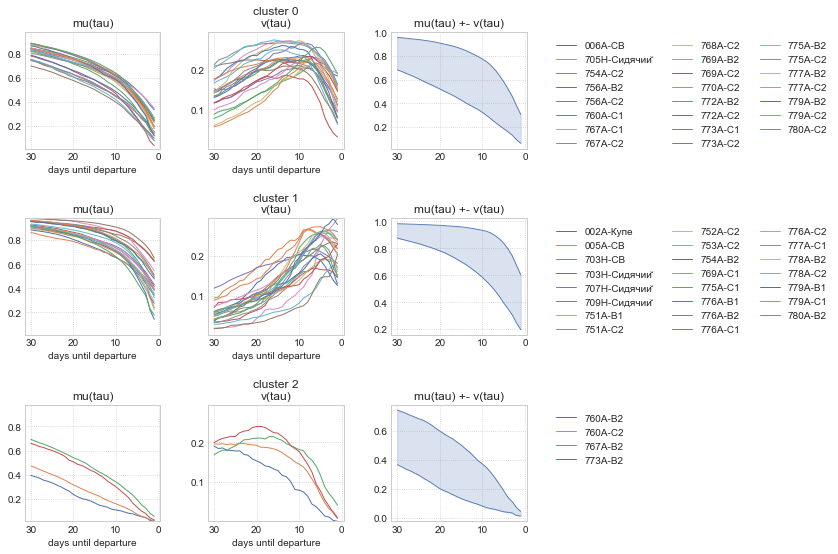

In [31]:
k = 3
kmeans = KMeans(n_clusters=k).fit(mean_v.values)
bi_clusters = kmeans.predict(mean_v.values)

clusters['both'] = bi_clusters

nrows = k
ncols = 3

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.6, wspace=0.35)

for cluster, (ax1, ax2, ax3) in zip(np.unique(bi_clusters), axes):
    mean_i = mean.loc[bi_clusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1, legend=False)
    ax1.set_title('mu(tau)')
    ax1.set_xlabel('days until departure')
    ax1.set_ylim(mu_min, mu_max)
    
    ax1.invert_xaxis()
    
    vi = v.loc[bi_clusters == cluster]
    
    vi.T.plot(ax=ax2, lw=1)
    ax2.legend(loc='upper left', bbox_to_anchor=(2.5, 1), ncol=vi.shape[0] // 8 + 1)
    ax2.set_title(f'cluster {cluster}\nv(tau)')
    ax2.set_xlabel('days until departure')
    ax2.set_ylim(vmin, vmax)
    
    ax2.invert_xaxis()
    
    mean_i = mean_i.mean(axis=0)
    vi = vi.mean(axis=0)
    
    lower = mean_i - vi
    upper = mean_i + vi
    
    ax3.plot(lower, c='C0', lw=0.8)
    ax3.plot(upper, c='C0', lw=0.8)
    ax3.fill_between(mean_i.index, lower, upper, color='C0', alpha=0.2)
    ax3.set_title('mu(tau) +- v(tau)')
    ax2.set_xlabel('days until departure')
    
    ax3.invert_xaxis()

plt.savefig(figures_dir / 'bi_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [42]:
clusters['direction'] = clusters.index.map(
    lambda s: 'from Moscow' if int(s.split('-')[0][:-1]) % 2 == 0 else 'to Moscow')

clusters['departure'] = data.drop_duplicates('train')\
    .set_index('train')[['departure_hour']]

clusters.head(2)

,mu,eig,both,direction,departure
train,,,,,
002А-Купе,2,1,1,from Moscow,23.916667
005А-СВ,2,0,1,to Moscow,22.483333


Интерпретируем кластеры:

1. Сопоставляем с классами.
2. Считаем время прибытия, время отправления.
3. Считаем цену.
4. Сопоставляем с направлением в/из Москвы.

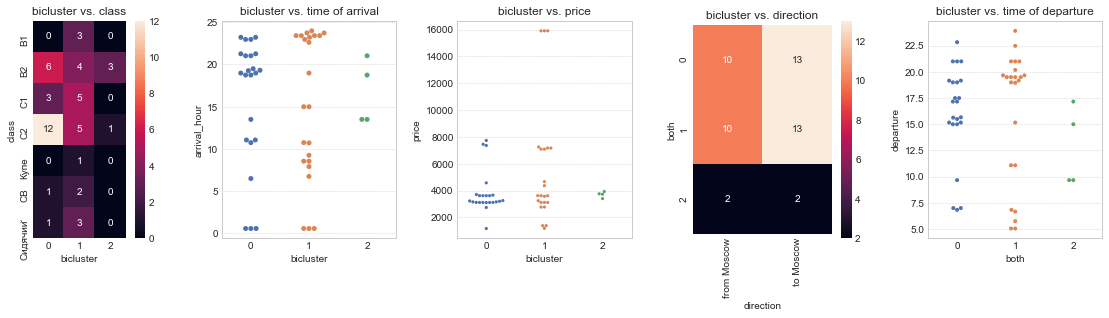

In [47]:
fig, (ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=5)
fig.set_size_inches(20, 4)
fig.subplots_adjust(wspace=0.35)

train_class = v.index.map(lambda x: x.split('-')[1])

# sns.heatmap(pd.crosstab(mu_clusters, eig_clusters).T, ax=ax1, annot=True, square=True)
# ax1.set_xlabel('mu_cluster')
# ax1.set_ylabel('eig_cluster')
# ax1.set_title('eig_cluster vs. mu_cluster')

sns.heatmap(pd.crosstab(bi_clusters, train_class).T, ax=ax2, annot=True, square=True)
ax2.set_xlabel('bicluster')
ax2.set_ylabel('class')
ax2.set_title('bicluster vs. class')

df = pd.Series(bi_clusters, index=mean.index, name='bicluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_hour']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.swarmplot(data=df, x='bicluster', y='arrival_hour', ax=ax3)
ax3.set_title('bicluster vs. time of arrival')

avg_price = data.groupby('train')['price'].median().reindex(mean.index)
df = pd.DataFrame({'bicluster': bi_clusters, 'price': avg_price})

sns.swarmplot(data=df, x='bicluster', y='price', ax=ax4, size=3.2)
ax4.set_title('bicluster vs. price')

sns.heatmap(pd.crosstab(clusters['both'], clusters['direction']), ax=ax5, square=True, annot=True)
ax5.tick_params(axis='x', rotation=90)
ax5.set_title('bicluster vs. direction')

sns.swarmplot(data=clusters, x='both', y='departure', size=4, ax=ax6)
ax6.set_title('bicluster vs. time of departure')

plt.savefig(figures_dir / 'explaining_bi_clusters.pdf', transparent=True, bbox_inches='tight')

Также сопоставляем с кластерами по недельным значениям ГК (из ноутбука `2_weekends.ipynb`).

In [51]:
weekly_avg_pc_clusters = pd.read_csv('../data/weekends/weekly_avg_pc_clusters.csv', index_col=0)

weekly_avg_pc_clusters.head(2)

,cluster,direction,departure,departs,group,weekends
train,,,,,,
701Н-СВ,0,to Moscow,7.750000,before 11am,"to Moscow, before 11am",[0]
751А-B1,0,to Moscow,5.050000,before 11am,"to Moscow, before 11am",[0]
751А-B2,0,to Moscow,5.050000,before 11am,"to Moscow, before 11am",[0]
751А-C1,0,to Moscow,5.050000,before 11am,"to Moscow, before 11am",[0]
751А-C2,0,to Moscow,5.050000,before 11am,"to Moscow, before 11am",[0]
...,...,...,...,...,...,...
756А-C2,3,from Moscow,7.000000,before 11am,"from Moscow, before 11am","[4, 5]"
759А-B2,3,to Moscow,9.166667,before 11am,"to Moscow, before 11am","[4, 5]"
759А-C2,3,to Moscow,9.166667,before 11am,"to Moscow, before 11am","[4, 5]"


<AxesSubplot:xlabel='both', ylabel='cluster'>

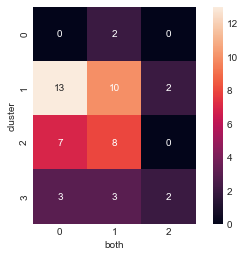

In [55]:
sns.heatmap(pd.crosstab(weekly_avg_pc_clusters['cluster'], clusters['both']), square=True, annot=True)

В целом толковой зависимости тут опять не видно. В плане последней картинки это и не удивительно, потому что PCA как раз таки позволяет отделить друг от друга "горизонтальную" динамику (изменение числа свободных мест при приближении к дате отправления) и "вертикальную" динамику (число свободных мест для разной даты отправления). Коль они отделяются друг от друга, было бы странно, если бы они как-то зависели друг от друга.

In [56]:
clusters.to_csv(results_dir / 'train_clusters.csv')